In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import json

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from qpfs import QPFS, MultivariateQPFS, MinimaxQPFS
from stat_tests import t_test_corr, check_correlation

lr = LinearRegression()

In [136]:
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
Y = np.repeat(y[:, np.newaxis], repeats=10, axis=1)
X = np.hstack([X, np.zeros((X.shape[0], 1))])

In [138]:
def VIF(X, idx):
    lr = LinearRegression()
    n_features = X.shape[1]
    y = X[:, idx]
    mask = np.arange(n_features) != idx
    X_i = X[:, mask]
    lr.fit(X_i, y)
    y_pred = lr.predict(X_i)
    r_squared = r2_score(y, y_pred)
    vif = 1. / np.maximum(1e-20, (1. - r_squared))
    return vif


def RMSE(y, p):
    return np.sqrt(np.mean((y - p) ** 2))

In [139]:
def score_vs_alpha3(qpfs, alpha3_array):
        
    alphas_history = []
    score_history = []
    for alpha3 in tqdm_notebook(alpha3_array):
        alphas = qpfs.get_alpha(alpha3)
        qpfs.solve_problem(alphas)
        alphas_history.append(alphas)
        score_history.append(qpfs.score)
    return score_history, alphas_history


def plot_score(score, filename):

    plt.figure(figsize=(6, 4))
    plt.semilogy(sorted(score)[::-1])
    plt.tight_layout()
    plt.xlabel('Features')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.savefig(filename, format='eps')
    plt.show()


def plot_features_vs_alpha(n_x, n_y, alpha3_array, score_history, figsize=(6.5, 4), legend_disable=False):

    plt.figure(figsize=figsize)

    prev = 0.
    for i in range(n_y):
        cur = [np.sum(a[n_x:n_x + i + 1]) for a in score_history]
        plt.plot(alpha3_array, cur, c='k', linewidth=1.)
        plt.fill_between(alpha3_array, cur, prev, alpha=0.15, edgecolor='k', 
                         label=r'{}'.format('$\mathbf{a}_{y,' + str(i + 1) + '}$'))
        prev = cur

    plt.ylim(0., 1.)
    plt.xlim(0., 1.)
    
    if legend_disable:
        bea = ()
    else:
        lgd = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                   ncol=n_y, mode="expand", borderaxespad=0., frameon=True, handletextpad=0.15)
        bea = (lgd,)
    
    plt.xlabel(r'$\alpha_3$')
    plt.tight_layout()
    plt.savefig('figs/features_vs_alpha_ecog_3.pdf', format='pdf', bbox_extra_artists=bea, bbox_inches='tight')
    plt.show()

In [141]:
def get_vif(X):
    if len(X.shape) == 1:
        vif = np.zeros(1)
    else:
        n = X.shape[1]
        vif = np.zeros(n)
        for j in tqdm_notebook(range(n), total=n, desc='VIF'):
            vif[j] = VIF(X, j)
    
    return vif

def categorize_features(vifx, vify, rel, vif_thres=10):
    n = len(vifx)
    features = {'nonrel': [], 'rel_nx_ny': [], 'rel_nx_y': [], 'rel_x_ny': [], 'rel_x_y': []}
    features['nonrel'] = np.arange(n)[np.all(rel, axis=1)].tolist()
    all_features = list(range(n))

    for j in all_features:
        if j in features['nonrel']:
            continue
        if vifx[j] < vif_thres:
            idxs_corr_not_zero = np.where(rel[j] == False)[0]
            if np.all(vify[idxs_corr_not_zero] < vif_thres):
                features['rel_nx_ny'].append(j)
            else:
                features['rel_nx_y'].append(j)
        else:
            idxs_corr_not_zero = np.where(rel[j] == False)[0]
            if np.all(vify[idxs_corr_not_zero] < vif_thres):
                features['rel_x_ny'].append(j)
            else:
                features['rel_x_y'].append(j)
    return features

In [143]:
def metric_vif(active_idxs):
    with open('res/ecog_vifx.json', 'r') as f:
        vifx = np.array(json.loads(f.read()))[active_idxs]
    return np.max(vifx)


def metric_stability(X):
    ev = np.linalg.eigh(X.T.dot(X))[0]
    return np.log(ev[0] / ev[-1])


def metric_complexity(X):
    return X.shape[1]


def metric_rmse(X, y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, y)
    y_pred = est.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))


def metric_bic(X, y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, y)
    y_pred = est.predict(X)
    m, p = X.shape
    return np.log(np.sum((y_pred - y) ** 2) / m) + p * np.log(m) * y.shape[1] / m


def metric_aic(X, y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, y)
    y_pred = est.predict(X)
    m, p = X.shape
    r = 1 if len(y.shape) == 1 else y.shape[1]
    return np.log(np.sum((y_pred - y) ** 2) / m) + 2 * r * p / m

In [144]:
def get_autoreg_Y(Y, step=1):
    m, t = Y.shape
    ar = np.zeros((m - step + 1, t * step))
    for i in range(step):
        for k in range(t):
            ar[:, i * t + k] = Y[i: m + i - step + 1, k]

    return ar

a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
get_autoreg_Y(a, step=3)

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]])

### Dataset generation

In [10]:
def generate_X_orthogonal(m, n, noise=1.):
    X = np.random.randn(m, n)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    U, _, _ = np.linalg.svd(X, full_matrices=False)
    U = U + noise * np.random.randn(m, n)
    U = (U - U.mean(axis=0)) / U.std(axis=0)
    return U


def generate_X_collinear(X, n=5, noise=0.1, tol=1e-13):
    u, s, vh = svd(X.T)
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    idxs = np.random.choice(np.arange(ns.shape[1]), size=n, replace=False)
    X_null = ns[:, idxs]
    
    n_samples = X_null.shape[0]
    X_new = np.zeros((n_samples, n))
    for i in range(n):
        n_cols = max(2, np.random.randint(n / 2) + 1)
        col_idxs = np.random.choice(np.arange(n), size=int(n_cols), replace=False)
        coef = np.random.randn(n_cols)
        coef /= np.sqrt(np.sum(coef ** 2))
        X_new[:, i] = X_null[:, col_idxs].dot(coef) + 0.1 * np.random.randn(n_samples)
    X_new = (X_new - X_new.mean(axis=0)) / X_new.std(axis=0)
    return X_new


def generate_Y(X, n, r=1, noise=1.):
    idxs = np.random.choice(np.arange(X.shape[1]), size=n, replace=False)
    W = np.random.randn(n, r)
    W_new = np.zeros([n, r])
    for i in range(r):
        n_cols = max(2, np.random.randint(r) + 1)
        col_idxs = np.random.choice(np.arange(r), size=int(n_cols), replace=False)
        coef = np.random.randn(n_cols)
        coef /= np.sqrt(np.sum(coef ** 2))
        W_new[:, i] = W[:, col_idxs].dot(coef) + 0.1 * np.random.randn(n)
    W_new = (W_new - W_new.mean(axis=0)) / W_new.std(axis=0)
    Y = X[:, idxs].dot(W_new) + noise * np.random.randn(X.shape[0], r)
    Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)
    return Y


def generate_Y_orthogonal(Y, n, noise=1.):
    idxs = np.random.choice(np.arange(Y.shape[1]), size=n, replace=False)
    nidxs = np.array(list(set(np.arange(Y.shape[1]).tolist()) - set(idxs)))
    U, _, _ = np.linalg.svd(Y[:, idxs], full_matrices=False)
    U = (U - U.mean(axis=0)) / U.std(axis=0)
    U = U + noise * np.random.randn(Y.shape[0], len(idxs))
    U = (U - U.mean(axis=0)) / U.std(axis=0)
    return np.hstack([U, Y[:, nidxs]])

In [ ]:
np.random.seed(42)

n_x_orth = 8
n_x_col = 10
n_x_rel = 5

n_y_orth = 8
n_y_col = 10

n_samples = 100

X_orth = generate_X_orthogonal(n_samples, n_x_orth)
X_col = generate_X_collinear(X_orth, n_x_col)

X = np.hstack([X_orth, X_col])

Y = generate_Y(X, n_x_rel, n_y_col + n_y_orth)
Y = generate_Y_orthogonal(Y, n_y_orth)


plt.imshow(np.abs(np.corrcoef(X.T)))
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(np.abs(np.corrcoef(Y.T)))
plt.colorbar()
plt.show()

In [347]:
vifx = get_vif(Y)
vifx

A Jupyter Widget

array([ 1.82282499,  2.00626527,  2.20100326,  1.18809704,  1.26206856,
        1.09024108,  1.18230596,  1.11004374,  3.94670934,  4.35503273,
        3.61821948,  3.77472595,  4.26870107,  3.42769311,  4.25923508,
        3.7708785 ,  4.25208643,  2.37161894])

### Test QPFS and MQPFS

In [146]:
qpfs = QPFS()
qpfs.fit(X, y)
print('\t'.join(['{:.4f}'.format(x) for x in qpfs.score]))

0.0722	0.0607	0.0455	0.1049	0.0425	0.1967	0.0371	0.0000	0.0247	0.0492	0.1248	0.0866	0.1551	0.0000


In [147]:
qpfs = QPFS()
qpfs.fit(X, Y)
print('\t'.join(['{:.4f}'.format(x) for x in qpfs.score]))

0.0721	0.0607	0.0455	0.1049	0.0425	0.1967	0.0371	0.0000	0.0247	0.0492	0.1248	0.0866	0.1551	0.0000


In [148]:
qpfs2 = MultivariateQPFS()

qpfs2.get_params(X, y)

alpha = np.mean(qpfs2.Qx) / (np.mean(qpfs2.Qx) + np.mean(qpfs2.B))
qpfs2.solve_problem([1 - alpha, alpha, 0.])
print('\t'.join(['{:.4f}'.format(x) for x in qpfs2.score]))

0.0779	0.0710	0.0436	0.1258	0.0442	0.1735	0.0463	0.0014	0.0339	0.0466	0.1173	0.0955	0.1229	0.0000	1.0000


In [149]:
qpfs2 = MultivariateQPFS()

qpfs2.get_params(X, Y)

alpha = np.mean(qpfs2.Qx) / (np.mean(qpfs2.Qx) + np.mean(qpfs2.B))
qpfs2.solve_problem([1 - alpha, alpha, 0.])
print('\t'.join(['{:.4f}'.format(x) for x in qpfs2.score]))

0.0775	0.0716	0.0508	0.1175	0.0492	0.1531	0.0518	0.0196	0.0441	0.0527	0.1097	0.0909	0.1117	0.0000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000


### Example

QPFS - bad, MQPFS - good

In [150]:
Q = np.array([[1., 0., .0],
               [0., 1., 0.8],
               [.0, 0.8, 1.]])
Qx = Q.copy()
print(Q)
r = 5
Qy = np.ones((r, r)) * 0.2
Qy[:r - 1, :r - 1] = np.ones((r - 1, r - 1))
np.fill_diagonal(Qy, 1.)
print(Qy)
B = np.hstack((np.repeat(np.array([[0.4], [0.5], [0.8]]), repeats=r - 1, axis=1), np.array([[0.], [.8], [.1]])))
print(B[:, :17])
b = np.mean(B, axis=1, keepdims=True)
print(b)

[[ 1.   0.   0. ]
 [ 0.   1.   0.8]
 [ 0.   0.8  1. ]]
[[ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 0.2  0.2  0.2  0.2  1. ]]
[[ 0.4  0.4  0.4  0.4  0. ]
 [ 0.5  0.5  0.5  0.5  0.8]
 [ 0.8  0.8  0.8  0.8  0.1]]
[[ 0.32]
 [ 0.56]
 [ 0.66]]


In [151]:
Q = shift_spectrum(Q)[0]
qpfs.Q, qpfs.b = Q, b
alpha = qpfs.get_alpha()
qpfs.solve_problem(alpha)
print('\t'.join(['{:.4f}'.format(x) for x in qpfs.score]))

0.3977	0.1767	0.4256


In [152]:
qpfs2.Qx = Qx
qpfs2.Qy = Qy
qpfs2.B = B

alphas = qpfs2.get_alpha(alpha3=0.3)
print(alphas)
qpfs2.solve_problem(alphas)

print('\t'.join(['{:.4f}'.format(x) for x in qpfs2.score]))

[ 0.35075922  0.34924078  0.3       ]
0.3829	0.5346	0.0825	0.1296	0.1296	0.1296	0.1296	0.4816


In [19]:
alpha3_array = np.linspace(0, 1, 300)
score_history, alphas_history = score_vs_alpha3(qpfs2, alpha3_array)

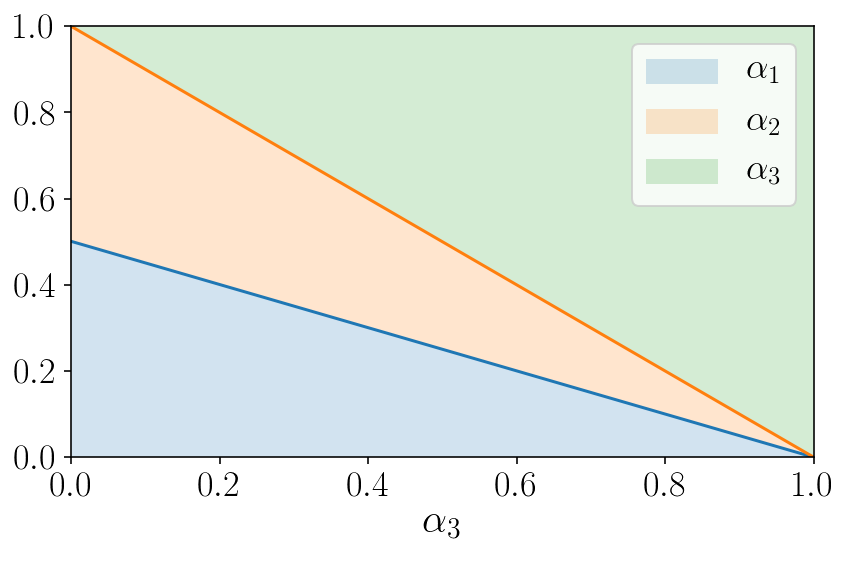

In [24]:
first_points = np.array([a[0] for a in alphas_history])
second_points = np.array([a[1] for a in alphas_history])
third_points = np.array([a[2] for a in alphas_history])

plt.plot(alpha3_array, first_points)
plt.fill_between(alpha3_array, first_points, alpha=0.2, label=r'$\alpha_1$')
plt.plot(alpha3_array, first_points + second_points)
plt.fill_between(alpha3_array, first_points + second_points, first_points, alpha=0.2, label=r'$\alpha_2$')
plt.fill_between(alpha3_array, 1., first_points + second_points, alpha=0.2, label=r'$\alpha_3$')

plt.ylim(0., 1.)
plt.xlim(0., 1.)

plt.legend()
plt.xlabel(r'$\alpha_3$')

plt.tight_layout()
plt.show()

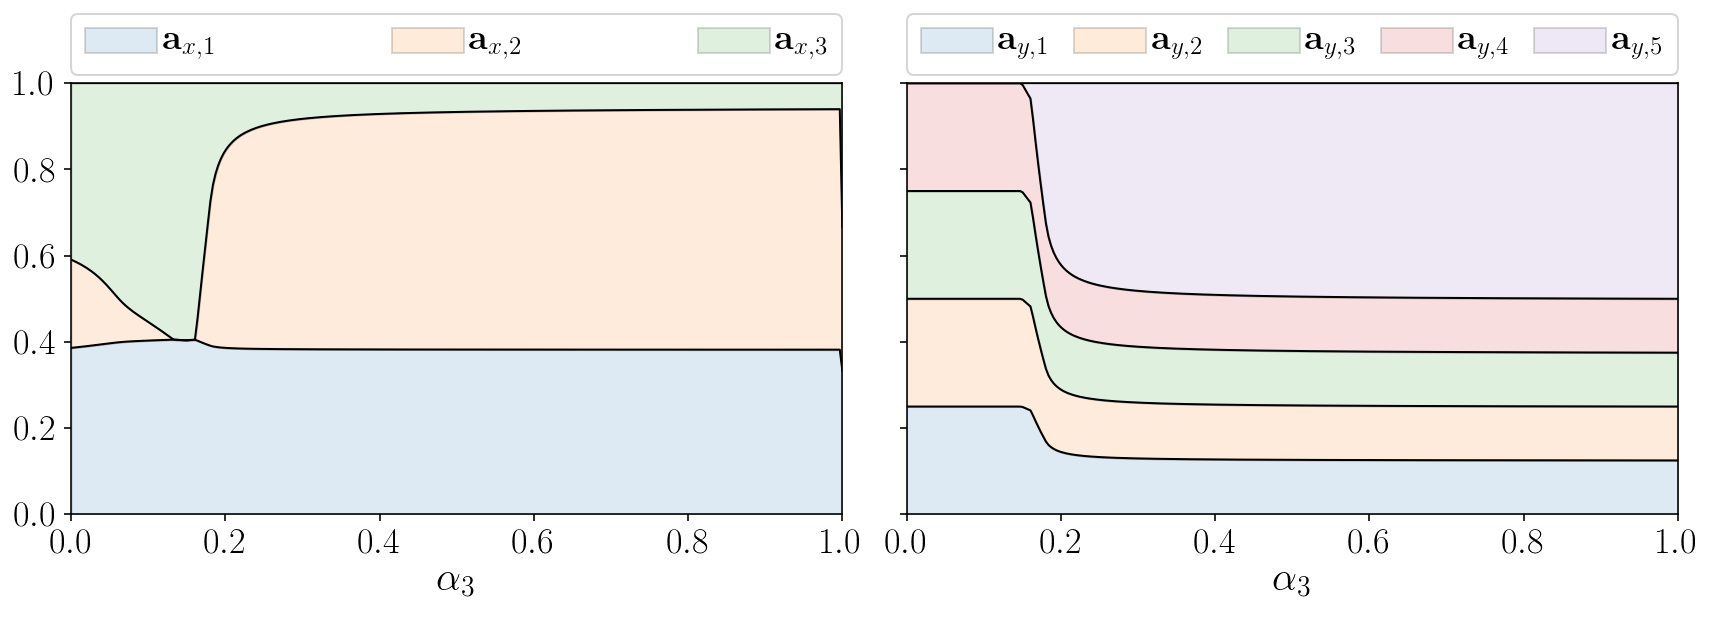

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
n_x, n_y = qpfs2.B.shape
prev = 0.
for i in range(n_x):
    cur = [np.sum(a[:i + 1]) for a in score_history]
    ax1.plot(alpha3_array, cur, c='k', linewidth=1.)
    ax1.fill_between(alpha3_array, cur, prev, edgecolor='k', alpha=.15, 
                     label=r'{}'.format('$\mathbf{a}_{x,' + str(i + 1) + '}$'))
    prev = cur

ax1.set_ylim(0., 1.)
ax1.set_xlim(0., 1.)

ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=n_x, mode="expand", borderaxespad=0., frameon=True, handletextpad=0.15)
ax1.set_xlabel(r'$\alpha_3$')

prev = 0.
for i in range(n_y):
    cur = [np.sum(a[n_x:n_x + i + 1]) for a in score_history]
    ax2.plot(alpha3_array, cur, c='k', linewidth=1.)
    ax2.fill_between(alpha3_array, cur, prev, alpha=0.15, edgecolor='k', 
                     label=r'{}'.format('$\mathbf{a}_{y,' + str(i + 1) + '}$'))
    prev = cur

ax2.set_ylim(0., 1.)
ax2.set_xlim(0., 1.)

lgd = ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=n_y, mode="expand", borderaxespad=0., frameon=True, handletextpad=0.15)
ax2.set_xlabel(r'$\alpha_3$')

fig.tight_layout()
fig.subplots_adjust()
fig.savefig('figs/features_vs_alpha.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### ECoG

In [155]:
Xtrain = sc.io.loadmat('./../data/ECoG_X_train.mat')['X_train'].reshape([-1, 32 * 27])
Ytrain = sc.io.loadmat('./../data/ECoG_Y_train.mat')['Y_train']

Xtest = sc.io.loadmat('./../data/ECoG_X_test.mat')['X_hold_out'].reshape([-1, 32 * 27])
Ytest = sc.io.loadmat('./../data/ECoG_Y_test.mat')['Y_hold_out']

n_samples, n_features = Xtrain.shape

print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(12801, 864) (12801, 3)
(6087, 864) (6087, 3)


In [156]:
lr.fit(Xtrain, Ytrain)

pred = lr.predict(Xtrain)
print('train: ', RMSE(Ytrain, pred))

pred = lr.predict(Xtest)
print('test: ', RMSE(Ytest, pred))

train:  38.441522087
test:  42.2703059983


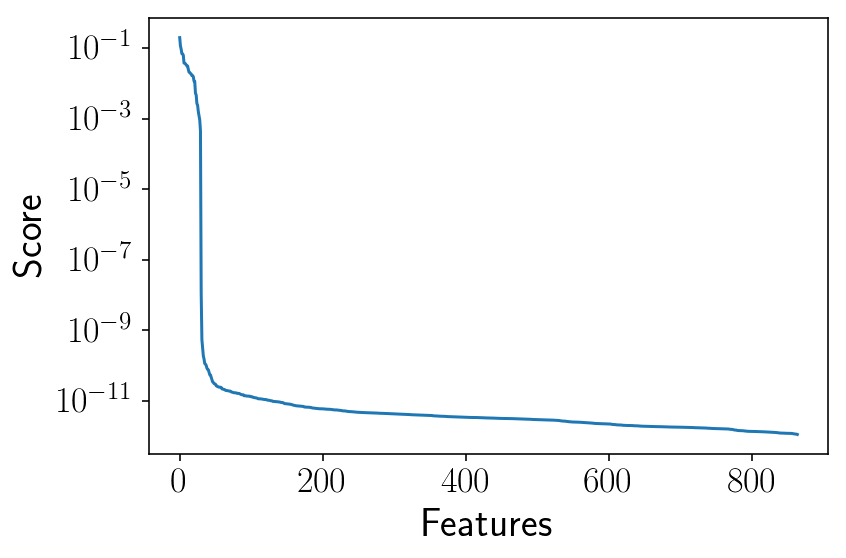

In [75]:
qpfs.fit(Xtrain, Ytrain)

plot_score(qpfs.score, 'figs/feature_scores_ex.eps')

In [28]:
k = 200
active_idxs = qpfs.score.argsort()[::-1][:200]
lr.fit(Xtrain[:, active_idxs], Ytrain)

pred = lr.predict(Xtrain[:, active_idxs])
print('train: ', RMSE(Ytrain, pred))

pred = lr.predict(Xtest[:, active_idxs])
print('test: ', RMSE(Ytest, pred))

train:  42.6338885951
test:  42.1127333117


In [31]:
def get_train_test_rmse(n_active_array, score, Xtrain, Ytrain, Xtest, Ytest):

    train_err_array = []
    test_err_array = []
    for k in n_active_array:
        active_idxs = score.argsort()[::-1][:k]
        lr.fit(Xtrain[:, active_idxs], Ytrain)
        pred = lr.predict(Xtrain[:, active_idxs])
        train_err_array.append(RMSE(Ytrain, pred))
        pred = lr.predict(Xtest[:, active_idxs])
        test_err_array.append(RMSE(Ytest, pred))

    train_err_array = np.array(train_err_array)
    test_err_array = np.array(test_err_array)
    return train_err_array, test_err_array

In [34]:
n_active_array = np.arange(1, n_features, 10)

train_err_array, test_err_array = get_train_test_rmse(n_active_array, qpfs.score, 
                                                      Xtrain, Ytrain, Xtest, Ytest)

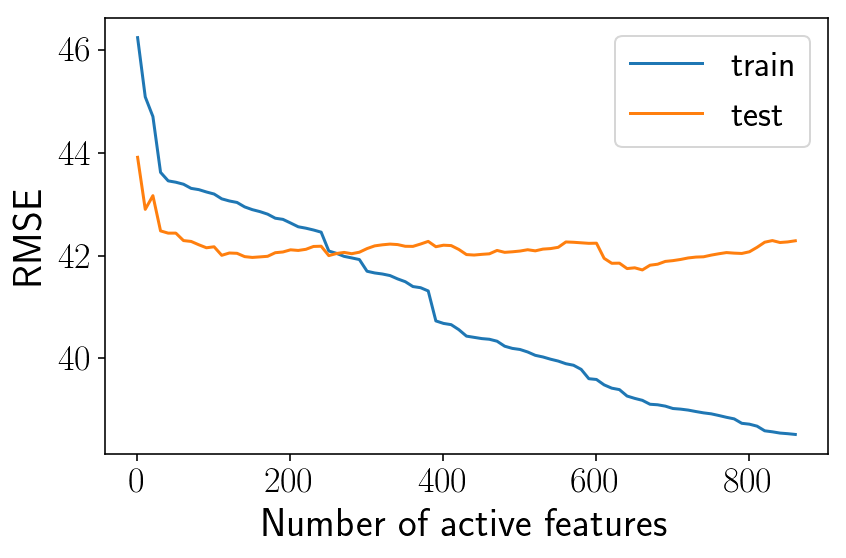

In [35]:
plt.figure(figsize=(6, 4))
plt.plot(n_active_array, train_err_array, label='train')
plt.plot(n_active_array, test_err_array, label='test')
plt.xlabel('Number of active features')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.savefig('figs/train_test_qpfs.eps', format='eps')
plt.show()

In [59]:
mqpfs = MultivariateQPFS()
mqpfs.get_params(Xtrain, Ytrain)
mqpfs.get_alpha()

array([ 0.14356797,  0.71052516,  0.14590687])

In [ ]:
alpha3_array = np.linspace(0, 1, 20)
score_history, alphas_history = score_vs_alpha3(mqpfs, alpha3_array)

np.save('res/features_vs_alpha_ecog_3_1.npy', np.array(score_history))

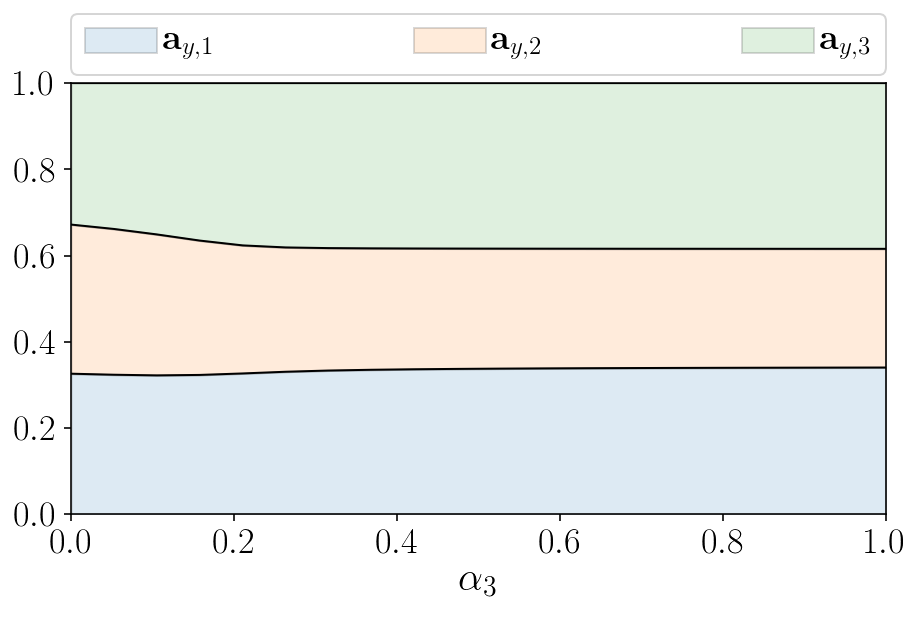

In [58]:
score_history = np.load('res/features_vs_alpha_ecog_3_1.npy')
alpha3_array = np.linspace(0, 1, 20)

n_x = n_features
n_y = len(score_history[0]) - n_features

plot_features_vs_alpha(n_x, n_y, alpha3_array, score_history, (6.5, 4))

### Feature categorization

In [169]:
rel = check_correlation(Xtrain, Ytrain)
vifx = get_vif(Xtrain)
vify = get_vif(Ytrain)

ecog_features = categorize_features(vifx, vify, rel)

with open('res/ecog_features_categorization.json', 'w') as f:
    f.write(json.dumps(ecog_features))
    
with open('res/ecog_vifx.json', 'w') as f:
    f.write(json.dumps(vifx.tolist()))
    
with open('res/ecog_vify.json', 'w') as f:
    f.write(json.dumps(vify.tolist()))

### Metrics

In [ ]:
print('vif:', metric_vif(np.arange(Xtrain.shape[1])))
print('stability:', metric_stability(Xtrain))
print('complexity:', metric_complexity(Xtrain))
print('rmse train:', metric_rmse(Xtrain, Ytrain))
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
print('rmse test:', metric_rmse(Xtest, Ytest, lr))
print('bic:', metric_bic(Xtrain, Ytrain))

### Autoregression on X,Y,Z

In [174]:
step = 15

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

(12787, 45) (12787, 864) (6073, 45) (6073, 864)


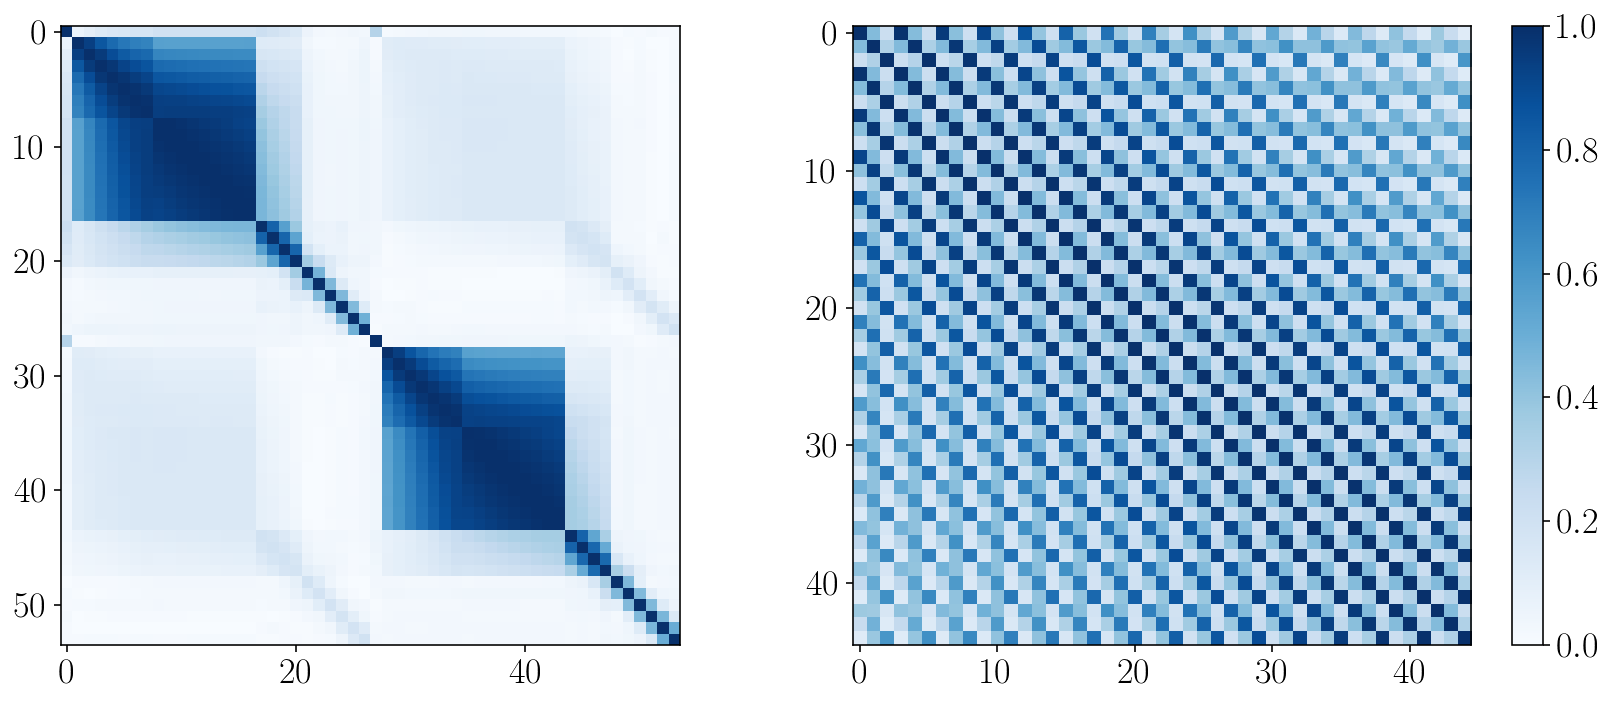

In [191]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(corr(Xtrain_ar[:, :54])), vmin=0., vmax=1., cmap='Blues')
#plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.abs(corr(Ytrain_ar)), vmin=0., vmax=1., cmap='Blues')
plt.colorbar()
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('figs/corr_matrix.eps', format='eps')
plt.show()

In [61]:
mqpfs.get_params(Xtrain_ar, Ytrain_ar)
print(mqpfs.get_alpha())

[ 0.15173295  0.77528227  0.07298478]


In [ ]:
alpha3_array = np.linspace(0, 1, 20)
score_history, alphas_history = score_vs_alpha3(mqpfs, alpha3_array)

np.save('res/features_vs_alpha_ecog_3_{}.npy'.format(step), np.array(score_history))

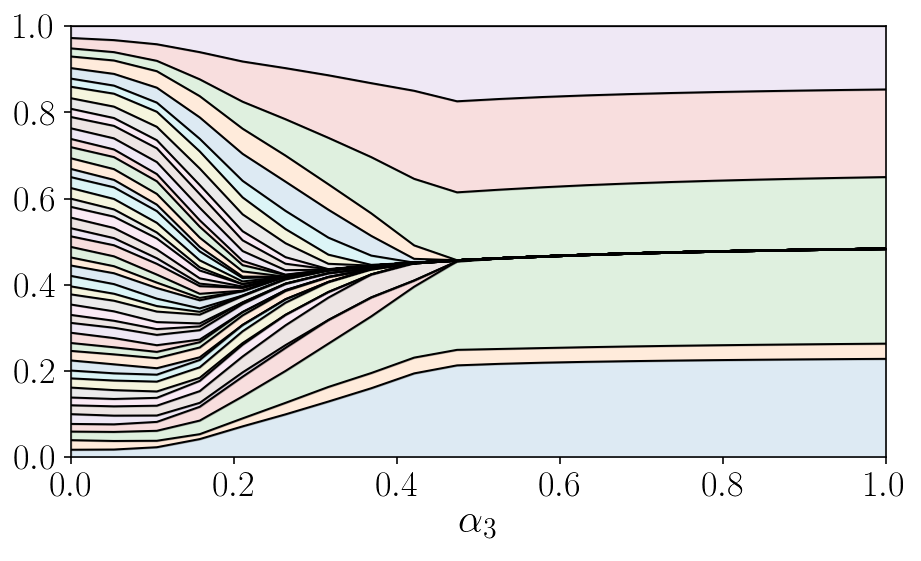

In [29]:
score_history = np.load('res/features_vs_alpha_ecog_3_{}.npy'.format(step))
alpha3_array = np.linspace(0, 1, 20)

n_x = n_features
n_y = len(score_history[0]) - n_features

plot_features_vs_alpha(n_x, n_y, alpha3_array, score_history, (6.5, 4), legend_disable=True)

In [62]:
step = 2

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

(12800, 6) (12800, 864) (6086, 6) (6086, 864)


In [63]:
mqpfs.get_params(Xtrain_ar, Ytrain_ar)
mqpfs.get_alpha()

array([ 0.15319487,  0.75828623,  0.0885189 ])

In [ ]:
alpha3_array = np.linspace(0, 1, 20)
score_history, alphas_array = score_vs_alpha3(mqpfs, alpha3_array)

np.save('res/features_vs_alpha_ecog_3_{}.npy'.format(step), np.array(score_history))

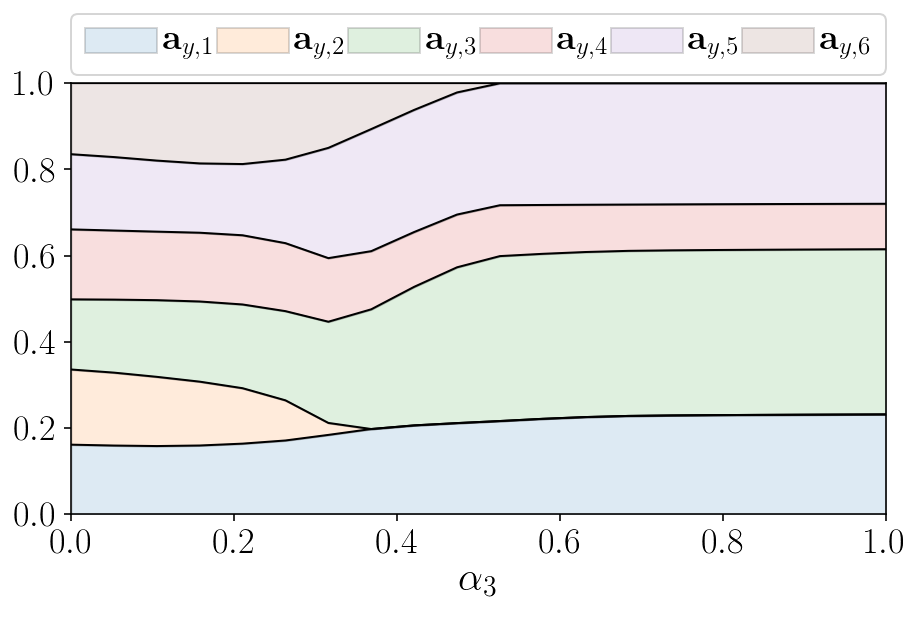

In [31]:
score_history = np.load('res/features_vs_alpha_ecog_3_{}.npy'.format(step))
alpha3_array = np.linspace(0, 1, 20)

n_x = n_features
n_y = len(score_history[0]) - n_features

plot_features_vs_alpha(n_x, n_y, alpha3_array, score_history, (6.5, 4))

In [64]:
step = 3

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

mqpfs.get_params(Xtrain_ar, Ytrain_ar)
mqpfs.get_alpha()

(12799, 9) (12799, 864) (6085, 9) (6085, 864)


array([ 0.15491434,  0.7664486 ,  0.07863706])

In [ ]:
alpha3_array = np.linspace(0, 1, 20)
score_history, alphas_array = score_vs_alpha3(mqpfs, alpha3_array)

np.save('res/features_vs_alpha_ecog_3_{}.npy'.format(step), np.array(score_history))

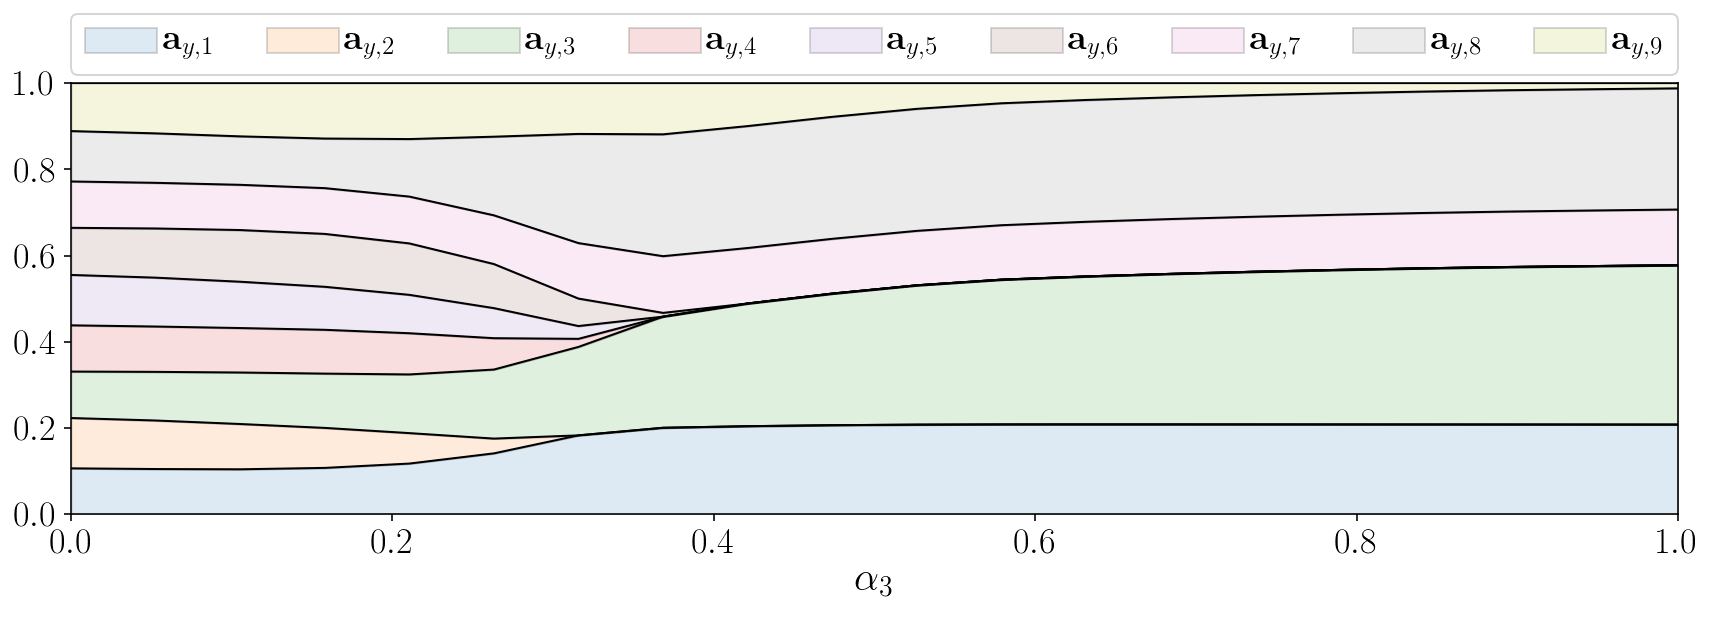

In [79]:
score_history = np.load('res/features_vs_alpha_ecog_3_{}.npy'.format(step))
alpha3_array = np.linspace(0, 1, 20)

n_x = n_features
n_y = len(score_history[0]) - n_features

plot_features_vs_alpha(n_x, n_y, alpha3_array, score_history, (12, 4))

### Metrics evaluation

In [157]:
def get_metrics(idxs, n_active_array, alpha3_array, score_history, Xtrain, Ytrain, Xtest, Ytest):
    results = {}
    results['score'] = []
    results['train_rmse'] =[]
    results['test_rmse'] = []
    results['stability'] = []
    results['vif'] = []
    results['aic'] = []
    results['bic'] = []
    results['alphas'] = alpha3_array[idxs].tolist()
    results['n_active_array'] = n_active_array.tolist()
    for idx in tqdm_notebook(idxs, total=len(idxs)):
        score = score_history[idx][:Xtrain.shape[1]]
        idxs_sort = score.argsort()[::-1]

        train_rmse = []
        test_rmse = []
        stability = []
        vif = []
        bic = []
        aic = []

        for k in n_active_array:
            active_idxs = idxs_sort[:k]
            lr.fit(Xtrain[:, active_idxs], Ytrain)
            train_rmse.append(metric_rmse(Xtrain[:, active_idxs], Ytrain, lr))
            test_rmse.append(metric_rmse(Xtest[:, active_idxs], Ytest, lr))
            stability.append(metric_stability(Xtrain[:, active_idxs]))
            vif.append(metric_vif(active_idxs))
            bic.append(metric_bic(Xtrain[:, active_idxs], Ytrain))
            aic.append(metric_aic(Xtrain[:, active_idxs], Ytrain))

        results['score'].append(score[idxs_sort].tolist())
        results['train_rmse'].append(train_rmse)
        results['test_rmse'].append(test_rmse)
        results['stability'].append(stability)
        results['vif'].append(vif)
        results['bic'].append(bic)
        results['aic'].append(aic)
        
    return results


def plot_metrics(results):
    fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
    for i, score in enumerate(results['score']):
        ax[0, 0].semilogy(score, label=results['alphas'][i])
    ax[0, 0].set_ylabel('Score')
    #ax[0, 0].legend()

    for i, train_rmse in enumerate(results['train_rmse']):
        ax[1, 0].plot(results['n_active_array'], train_rmse, label=results['alphas'][i])
    ax[1, 0].set_ylabel('RMSE train')
    #ax[1, 0].legend()

    for i, test_rmse in enumerate(results['test_rmse']):
        ax[2, 0].plot(results['n_active_array'], test_rmse, label=results['alphas'][i])
    ax[2, 0].set_xlabel('Features')
    ax[2, 0].set_ylabel('RMSE test')
    #ax[2, 0].legend()

    for i, stability in enumerate(results['stability']):
        ax[0, 1].plot(results['n_active_array'], stability, label=results['alphas'][i])
    ax[0, 1].set_ylabel('Stability')
    ax[0, 1].legend()

    for i, vif in enumerate(results['vif']):
        ax[1, 1].plot(results['n_active_array'], vif, label=results['alphas'][i])
    ax[1, 1].set_ylabel('VIF')
    #ax[1, 1].legend()

    for i, bic in enumerate(results['aic']):
        ax[2, 1].plot(results['n_active_array'], bic, label=results['alphas'][i])

    ax[2, 1].set_xlabel('Features')
    ax[2, 1].set_ylabel('AIC')
    #ax[2, 1].legend()

    fig.tight_layout()
    plt.savefig('figs/ecog_3_{}_metrics.eps'.format(step), format='eps')
    plt.show()

In [159]:
mmqpfs = MinimaxQPFS()

mmqpfs.get_params(X, Y)

In [160]:
alphas = mmqpfs.get_alpha()
mmqpfs.solve_problem(alphas)

In [157]:
mmqpfs.get_params(Xtrain, Ytrain)

In [158]:
alphas = mmqpfs.get_alpha()
#alphas = np.array([1., 1., 1.])

mmqpfs.solve_problem(alphas)

### QPFS vs MQPFS vs MMQPFS

In [162]:
qpfs = QPFS()
mqpfs = MultivariateQPFS()
mmqpfs_minmax = MinimaxQPFS(mode='minmax')
mmqpfs_maxmin = MinimaxQPFS(mode='maxmin')
mmqpfs_dual_woy = MinimaxQPFS(mode='dual_woy')

In [163]:
step = 1

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

(12801, 3) (12801, 864) (6087, 3) (6087, 864)


In [164]:
qpfs.get_params(Xtrain_ar, Ytrain_ar)
mqpfs.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_minmax.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_maxmin.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_dual_woy.get_params(Xtrain_ar, Ytrain_ar)

In [165]:
print(qpfs.get_alpha())
print(mqpfs.get_alpha())
print(mmqpfs_minmax.get_alpha())
print(mmqpfs_maxmin.get_alpha())
print(mmqpfs_dual_woy.get_alpha())

0.623823423961
[ 0.14356797  0.71052516  0.14590687]
[ 0.15678164  0.77998418  0.06323418]
[ 0.15678164  0.77998418  0.06323418]
[ 0.15678164  0.77998418  0.06323418]


In [166]:
qpfs.solve_problem(qpfs.get_alpha())
mqpfs.solve_problem(mqpfs.get_alpha())
mmqpfs_minmax.solve_problem(mmqpfs_minmax.get_alpha())
mmqpfs_maxmin.solve_problem(mmqpfs_maxmin.get_alpha())
mmqpfs_dual_woy.solve_problem(mmqpfs_dual_woy.get_alpha())

In [167]:
print(qpfs.score.shape)
print(mqpfs.score.shape)
print(mmqpfs_minmax.ax.shape)
print(mmqpfs_maxmin.ax.shape)
print(mmqpfs_dual_woy.ax.shape)

(864,)
(867,)
(864,)
(864,)
(864,)


In [168]:
score_history = [qpfs.score, mqpfs.score, mmqpfs_minmax.ax, mmqpfs_maxmin.ax, mmqpfs_dual_woy.ax]
n_active_array = np.arange(1, n_features, 20)

In [169]:
algs = np.array(['RelAgg', 'SymImp', 'MinMax', 'MaxMin', 'MaxRel'])
results = get_metrics(np.arange(len(algs)), n_active_array, algs, 
                      score_history, Xtrain_ar, Ytrain_ar, Xtest_ar, Ytest_ar)

with open('res/qpfs_vs_mqpfs_ecog_3_{}_results.json'.format(step), 'w') as f:
    f.write(json.dumps(results))

A Jupyter Widget

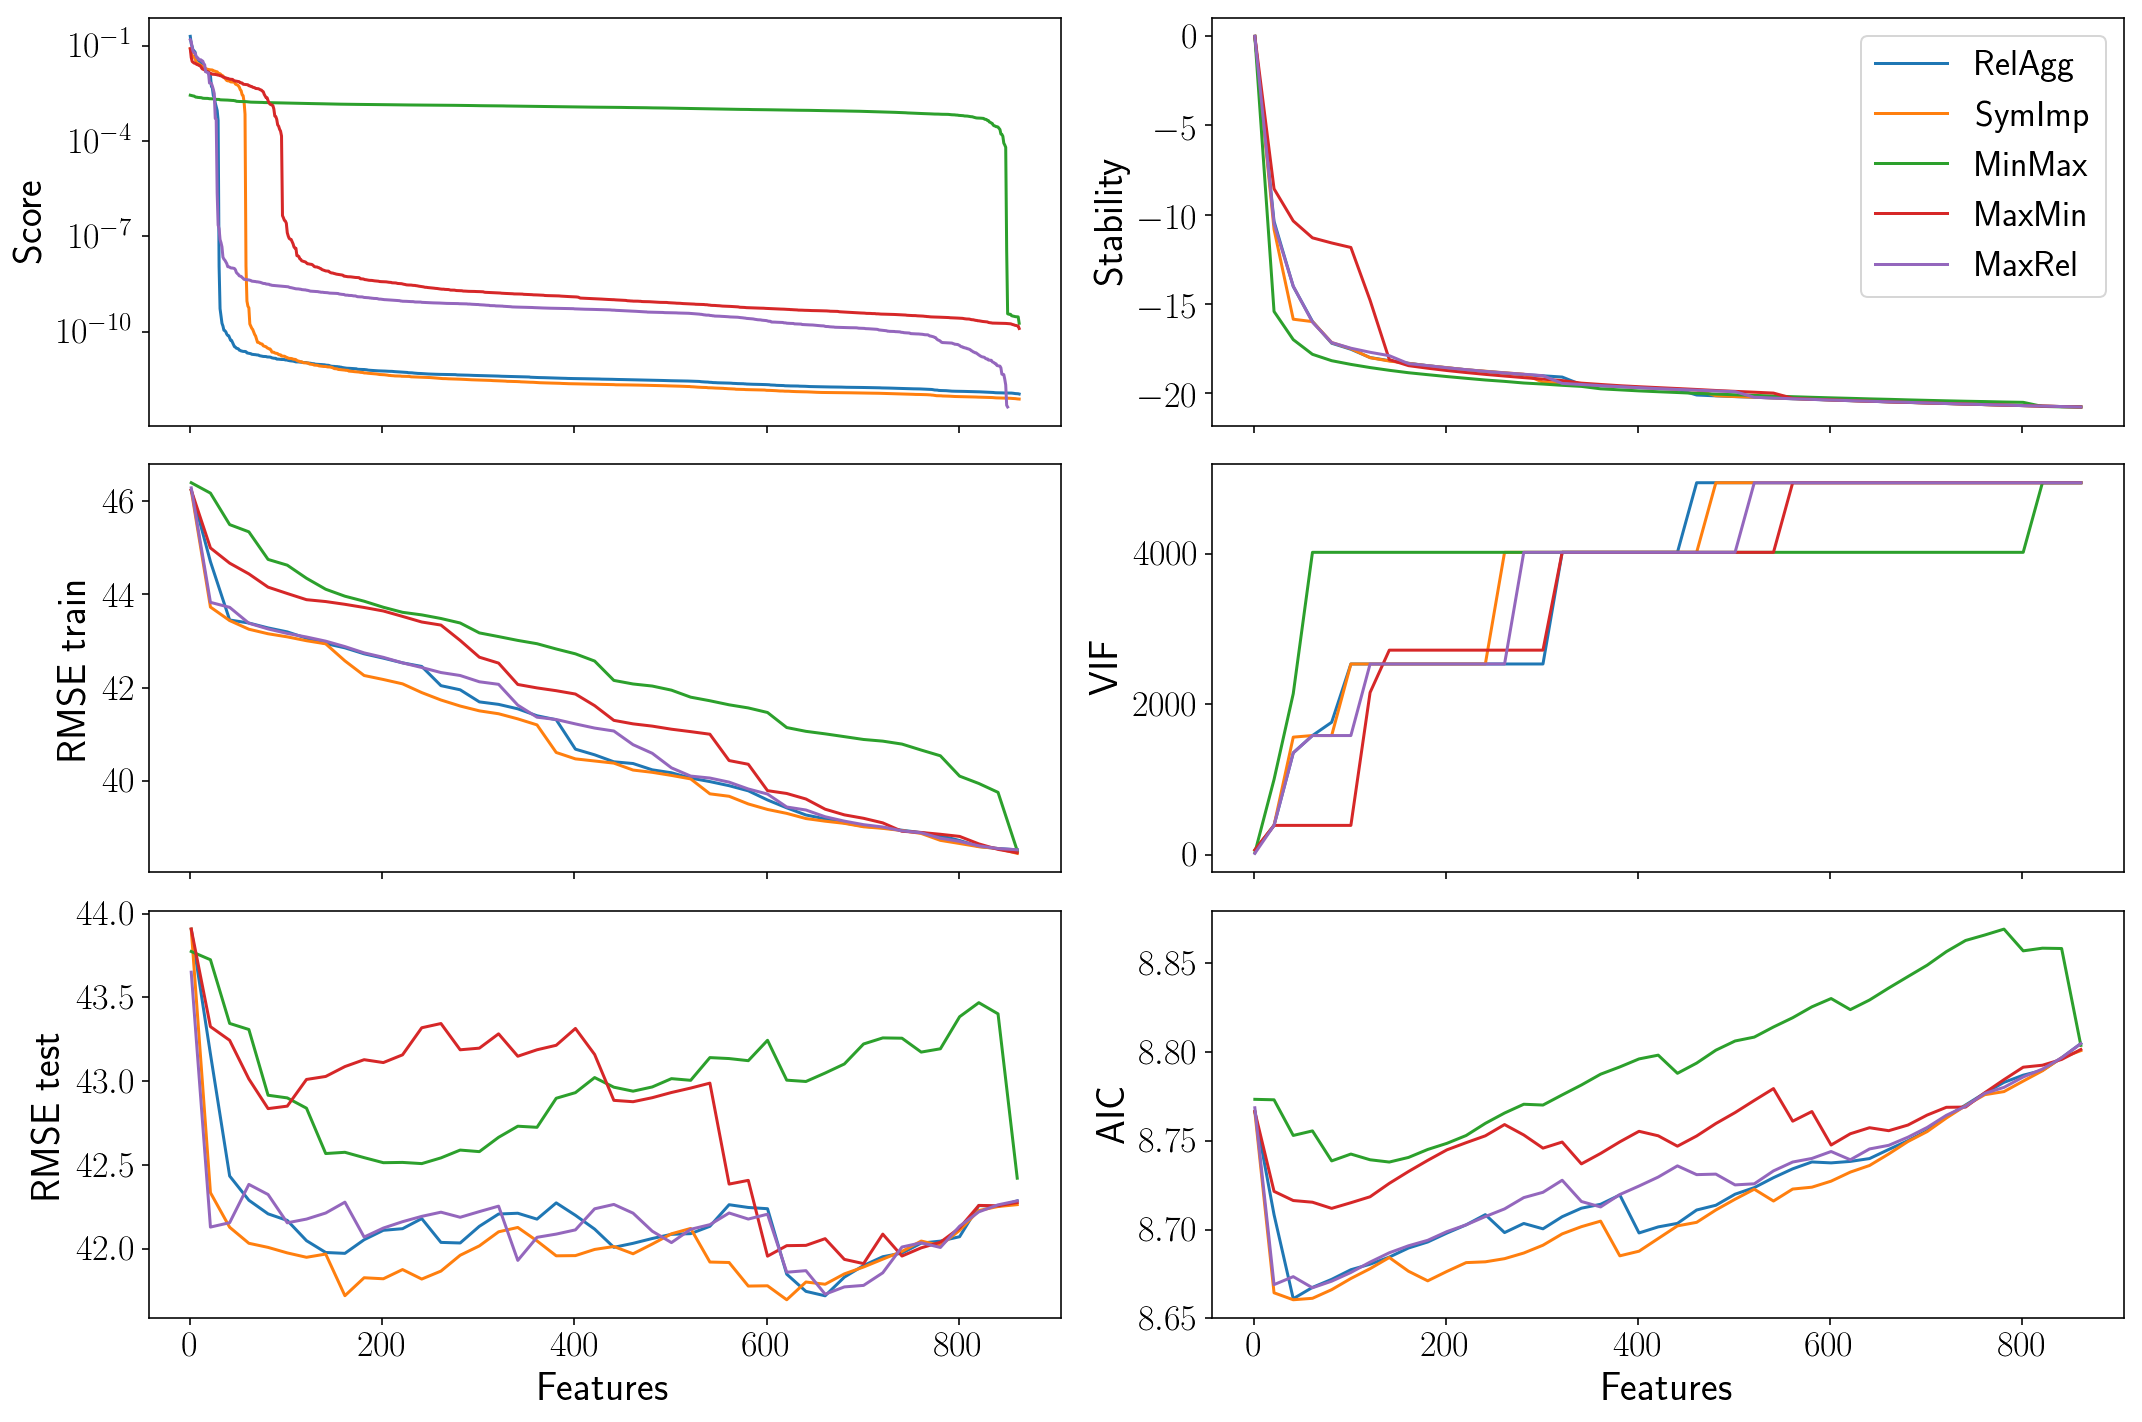

In [170]:
plot_metrics(results)

(12800, 6) (12800, 864) (6086, 6) (6086, 864)


A Jupyter Widget

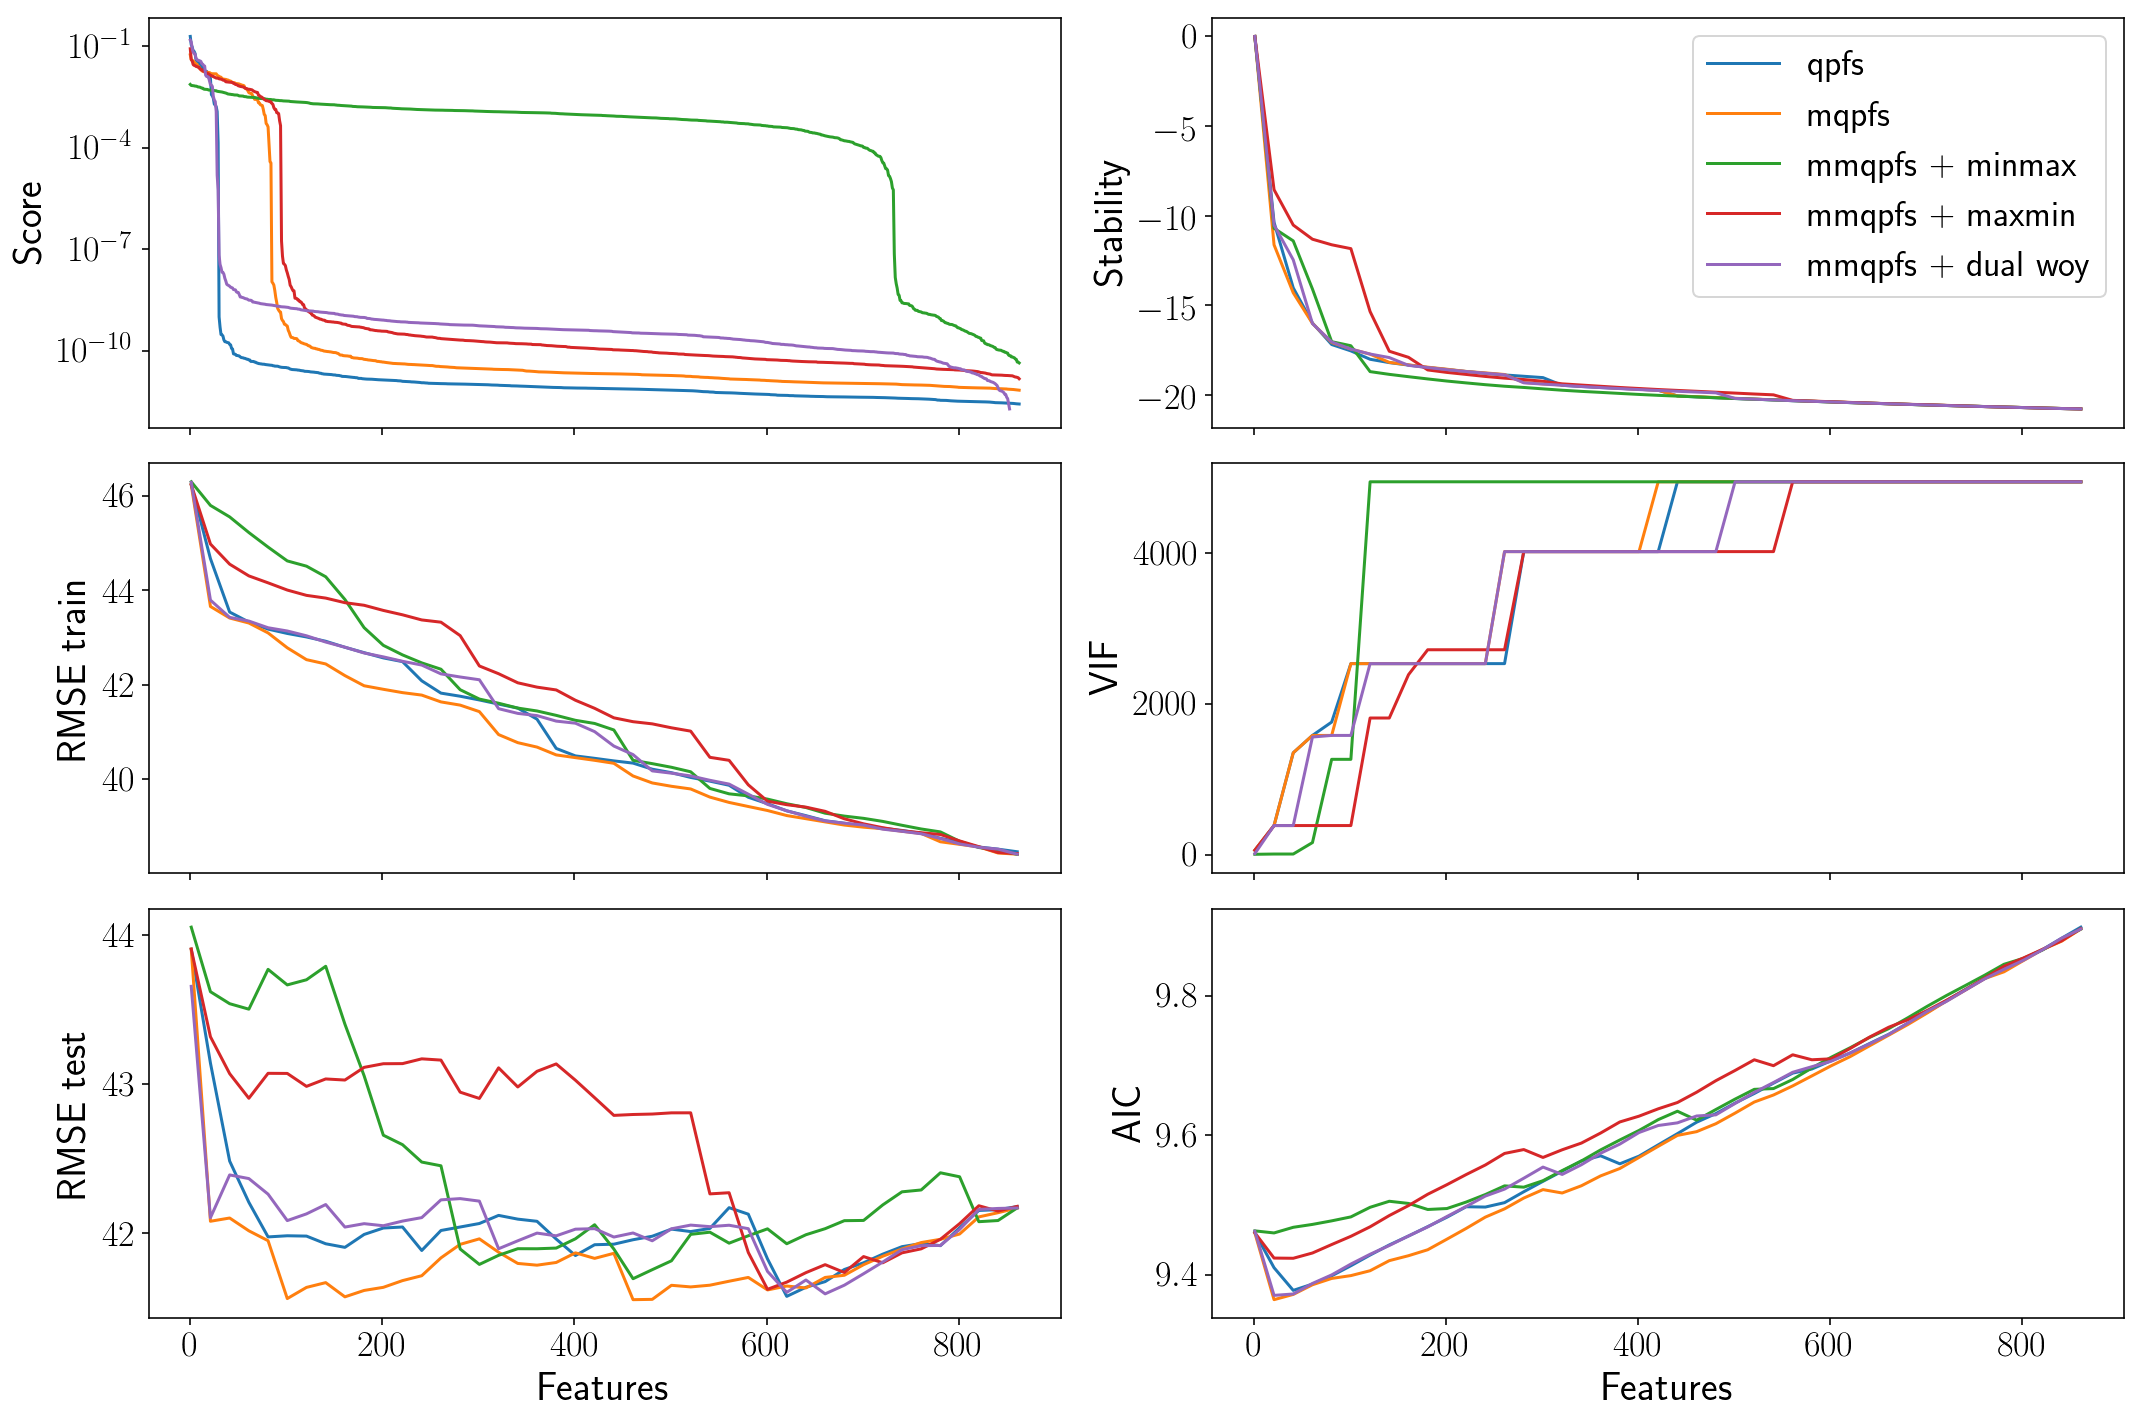

In [173]:
step = 2

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

qpfs.get_params(Xtrain_ar, Ytrain_ar)
mqpfs.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_minmax.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_maxmin.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_dual_woy.get_params(Xtrain_ar, Ytrain_ar)

qpfs.solve_problem(qpfs.get_alpha())
mqpfs.solve_problem(mqpfs.get_alpha())
mmqpfs_minmax.solve_problem(mmqpfs_minmax.get_alpha())
mmqpfs_maxmin.solve_problem(mmqpfs_maxmin.get_alpha())
mmqpfs_dual_woy.solve_problem(mmqpfs_dual_woy.get_alpha())

score_history = [qpfs.score, mqpfs.score, mmqpfs_minmax.ax, mmqpfs_maxmin.ax, mmqpfs_dual_woy.ax]
n_active_array = np.arange(1, n_features, 20)

results = get_metrics([0, 1, 2, 3, 4], n_active_array, 
                      np.array(['qpfs', 'mqpfs', 'mmqpfs + minmax', 'mmqpfs + maxmin', 'mmqpfs + dual woy']), 
                      score_history, Xtrain_ar, Ytrain_ar, Xtest_ar, Ytest_ar)

with open('res/qpfs_vs_mqpfs_ecog_3_{}_results.json'.format(step), 'w') as f:
    f.write(json.dumps(results))
    
plot_metrics(results)

(12799, 9) (12799, 864) (6085, 9) (6085, 864)


A Jupyter Widget

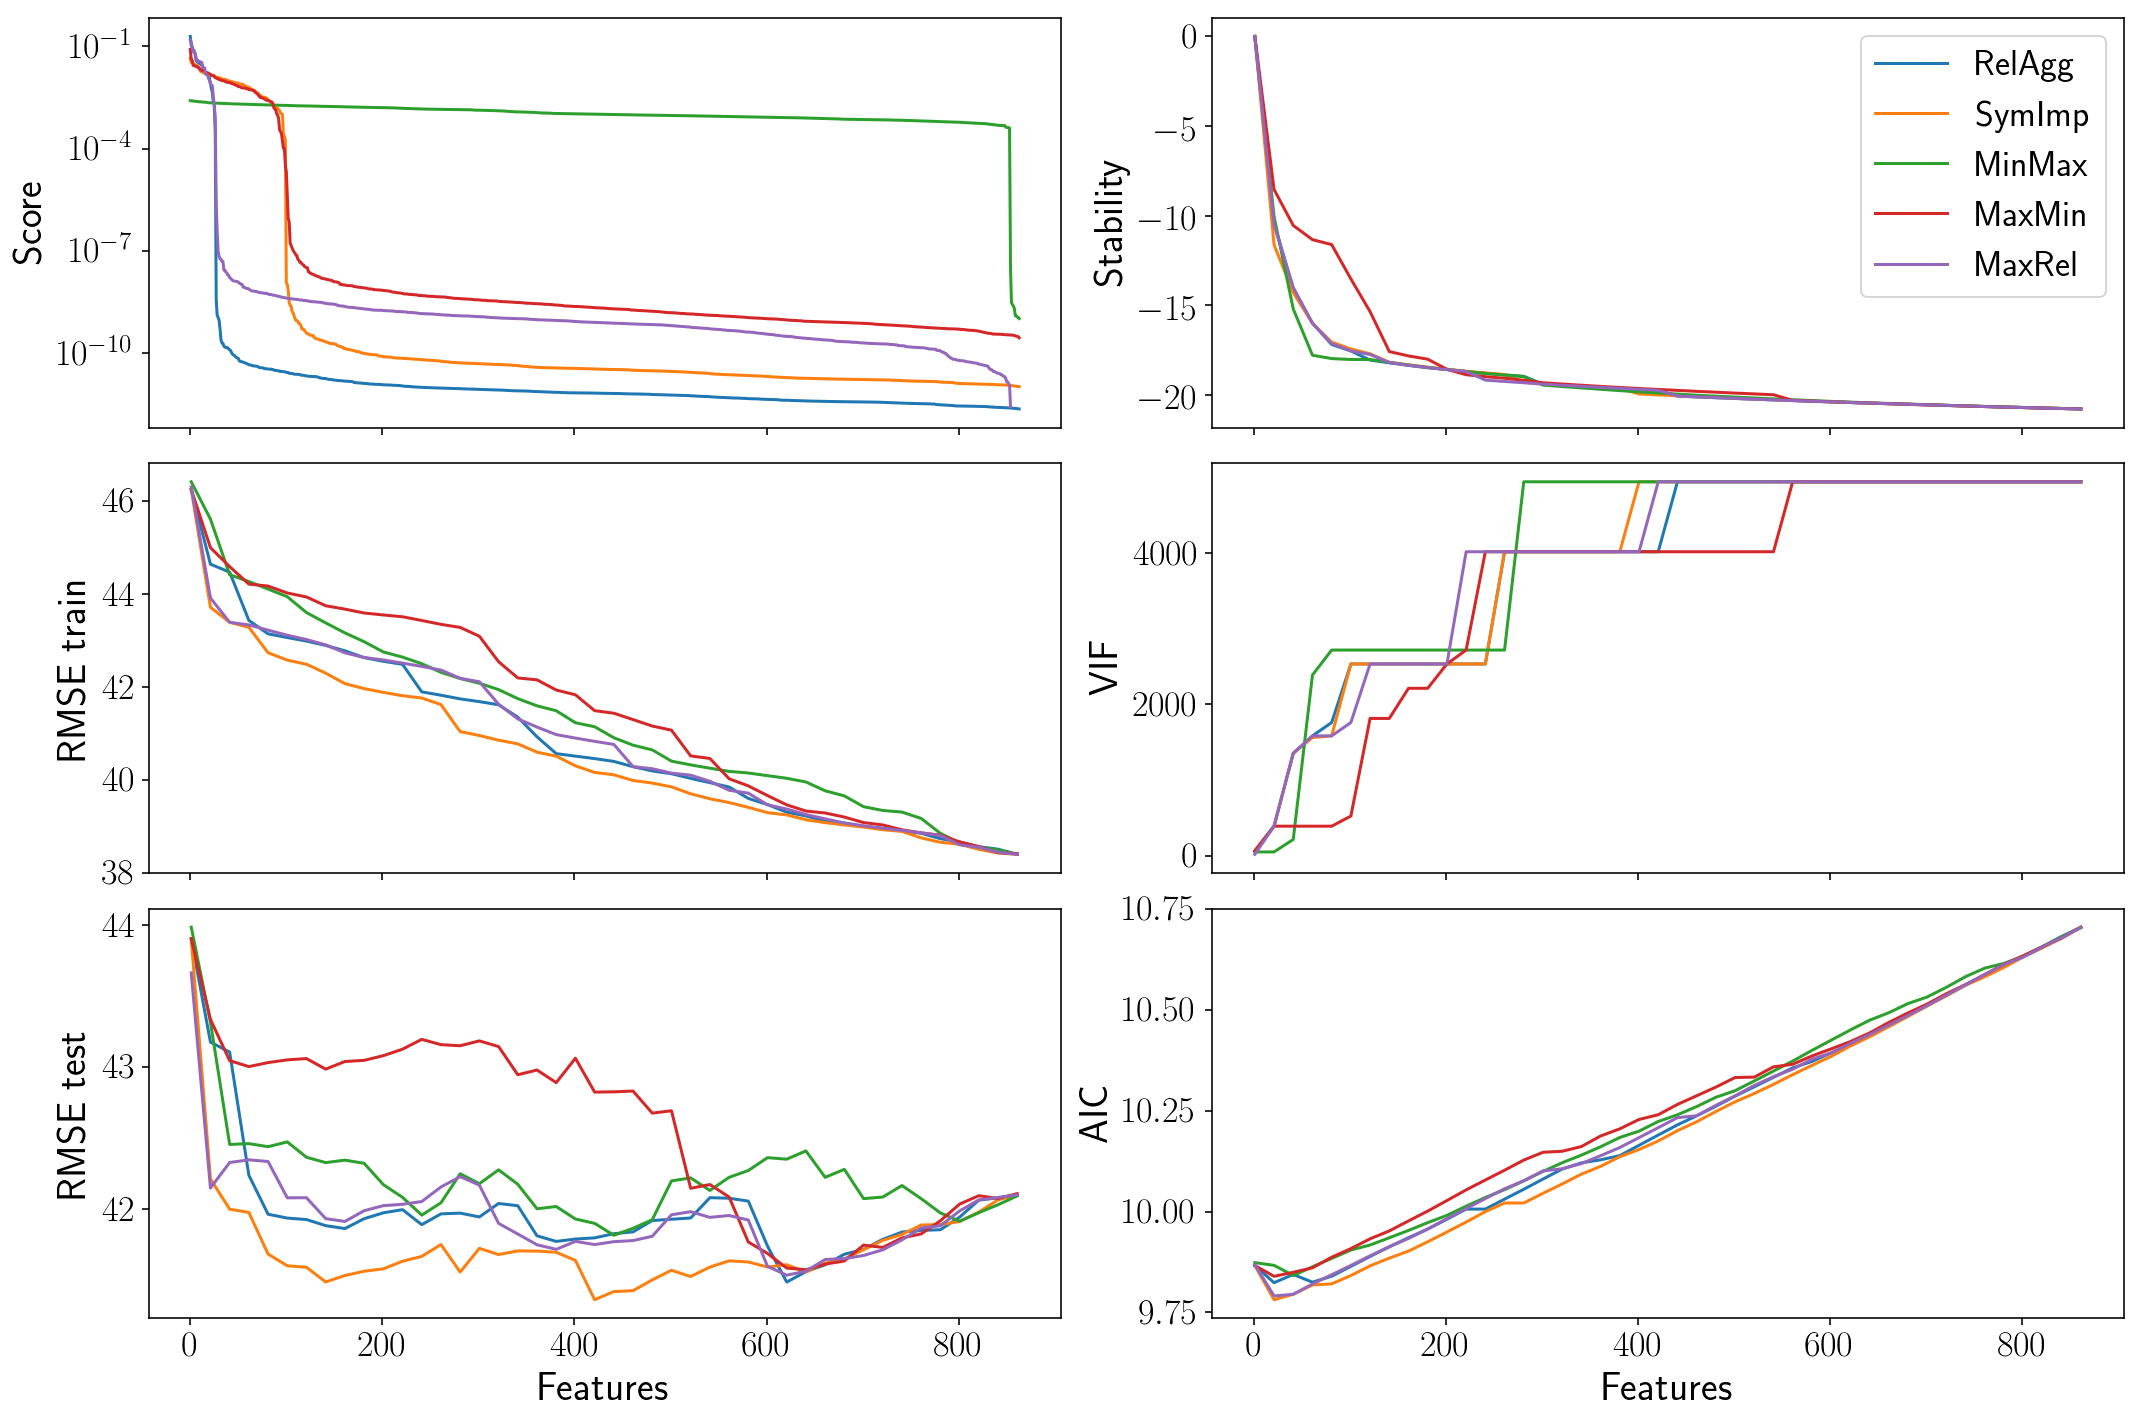

In [171]:
step = 3

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

qpfs.get_params(Xtrain_ar, Ytrain_ar)
mqpfs.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_minmax.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_maxmin.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_dual_woy.get_params(Xtrain_ar, Ytrain_ar)

qpfs.solve_problem(qpfs.get_alpha())
mqpfs.solve_problem(mqpfs.get_alpha())
mmqpfs_minmax.solve_problem(mmqpfs_minmax.get_alpha())
mmqpfs_maxmin.solve_problem(mmqpfs_maxmin.get_alpha())
mmqpfs_dual_woy.solve_problem(mmqpfs_dual_woy.get_alpha())

score_history = [qpfs.score, mqpfs.score, mmqpfs_minmax.ax, mmqpfs_maxmin.ax, mmqpfs_dual_woy.ax]
n_active_array = np.arange(1, n_features, 20)

algs = np.array(['RelAgg', 'SymImp', 'MinMax', 'MaxMin', 'MaxRel'])
results = get_metrics(np.arange(len(algs)), n_active_array, algs, 
                      score_history, Xtrain_ar, Ytrain_ar, Xtest_ar, Ytest_ar)

with open('res/qpfs_vs_mqpfs_ecog_3_{}_results.json'.format(step), 'w') as f:
    f.write(json.dumps(results))
    
plot_metrics(results)

(12787, 45) (12787, 864) (6073, 45) (6073, 864)


A Jupyter Widget

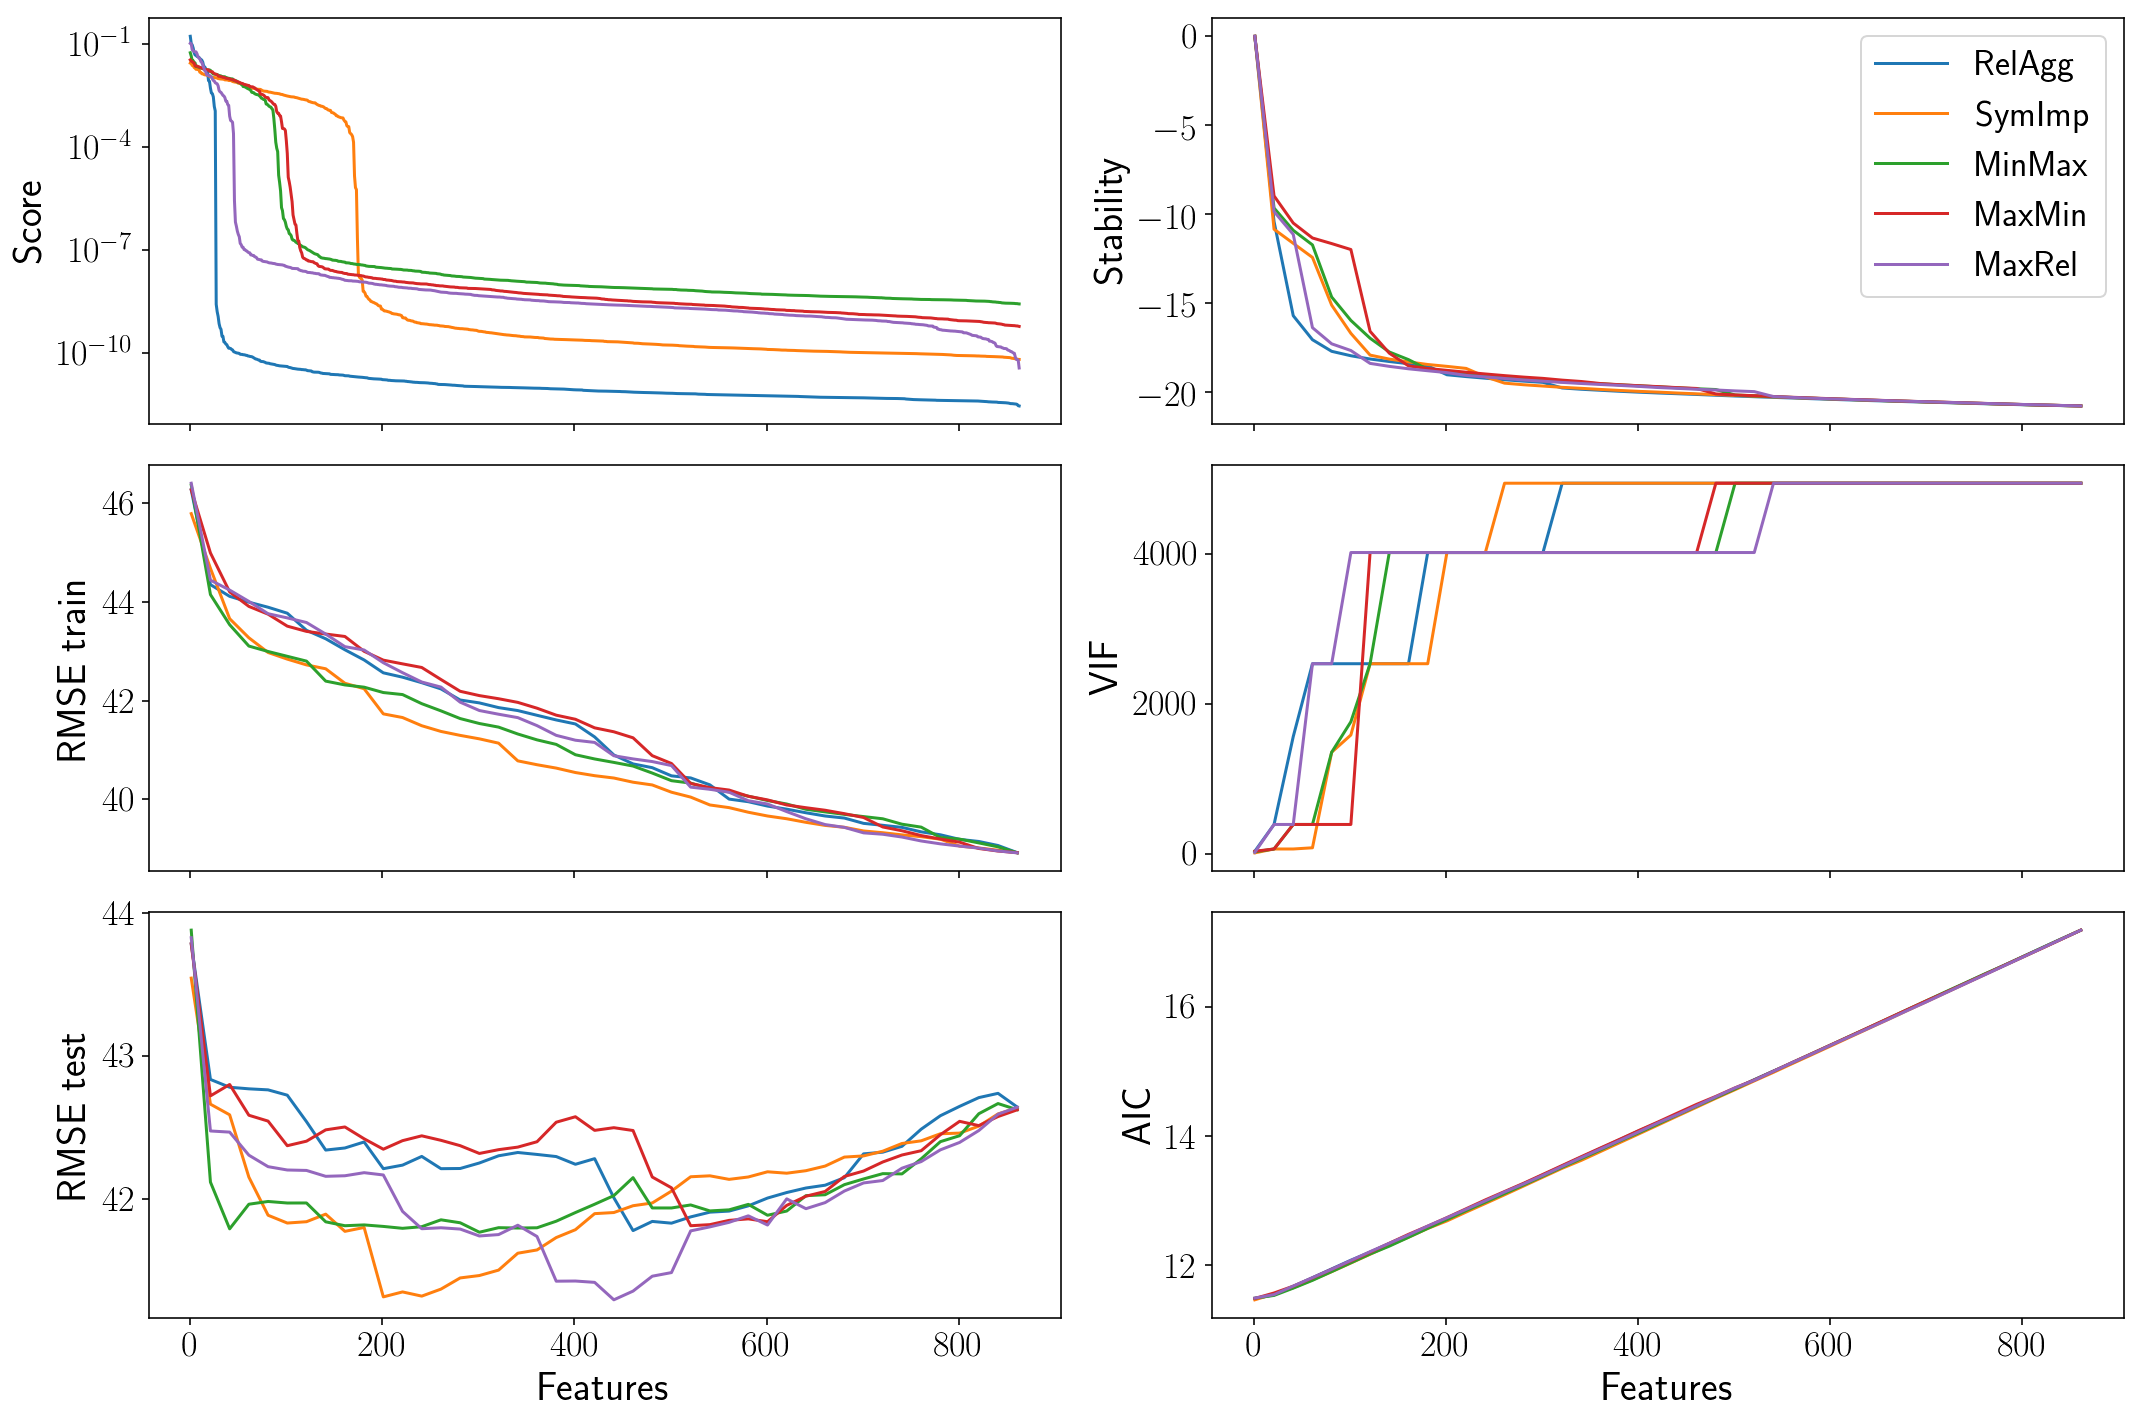

In [172]:
step = 15

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

qpfs.get_params(Xtrain_ar, Ytrain_ar)
mqpfs.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_minmax.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_maxmin.get_params(Xtrain_ar, Ytrain_ar)
mmqpfs_dual_woy.get_params(Xtrain_ar, Ytrain_ar)

qpfs.solve_problem(qpfs.get_alpha())
mqpfs.solve_problem(mqpfs.get_alpha())
mmqpfs_minmax.solve_problem(mmqpfs_minmax.get_alpha())
mmqpfs_maxmin.solve_problem(mmqpfs_maxmin.get_alpha())
mmqpfs_dual_woy.solve_problem(mmqpfs_dual_woy.get_alpha())

score_history = [qpfs.score, mqpfs.score, mmqpfs_minmax.ax, mmqpfs_maxmin.ax, mmqpfs_dual_woy.ax]
n_active_array = np.arange(1, n_features, 20)

algs = np.array(['RelAgg', 'SymImp', 'MinMax', 'MaxMin', 'MaxRel'])
results = get_metrics(np.arange(len(algs)), n_active_array, algs, 
                      score_history, Xtrain_ar, Ytrain_ar, Xtest_ar, Ytest_ar)

with open('res/qpfs_vs_mqpfs_ecog_3_{}_results.json'.format(step), 'w') as f:
    f.write(json.dumps(results))
    
plot_metrics(results)